In [1]:
import torch
import numpy as np
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

In [2]:
import random

random_seed = 42

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

In [3]:
# https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_blobs.html

n_dim = 2
x_train, y_train = make_blobs(n_samples=80, n_features=n_dim,
                              centers=[[0,0],[1,1],[1,0],[0,1]],
                              shuffle=True, cluster_std=0.15)
x_test, y_test = make_blobs(n_samples=20, n_features=n_dim,
                            centers=[[0,0],[1,1],[1,0],[0,1]],
                            shuffle=True, cluster_std=0.15)

In [4]:
# 15번째 sample까지만 print
for i, x in enumerate(x_train):
    print(x, y_train[i])
    if i == 15 : break

[1.00903453 0.36948632] 2
[1.01456163 0.14529675] 2
[-0.08165741  0.01663839] 0
[-0.09025599  0.27784173] 0
[0.08802856 1.32856834] 3
[ 0.01012923 -0.21371223] 0
[1.13731032 0.04931267] 2
[1.04441804 0.03915829] 2
[-0.24112249  1.02769508] 3
[1.01376412 0.70186466] 1
[ 0.21984732 -0.03386645] 0
[-0.15192467  0.0471371 ] 0
[-0.18554261  0.80193151] 3
[1.01305706 0.9551489 ] 1
[ 1.22168411 -0.07774053] 2
[ 0.71218432 -0.00397708] 2


In [5]:
# label 0, 1 -> 0으로 매핑
# label 2, 3 -> 1로 매핑

def label_map(y_, from_, to_):
    y = np.copy(y_)
    for f in from_:
        y[y_ == f] = to_
    return y

y_train = label_map(y_train, [0, 1], 0)
y_train = label_map(y_train, [2, 3], 1)
y_test = label_map(y_test, [0, 1], 0)
y_test = label_map(y_test, [2, 3], 1)

In [6]:
y_train.max(), y_train.min()

(1, 0)

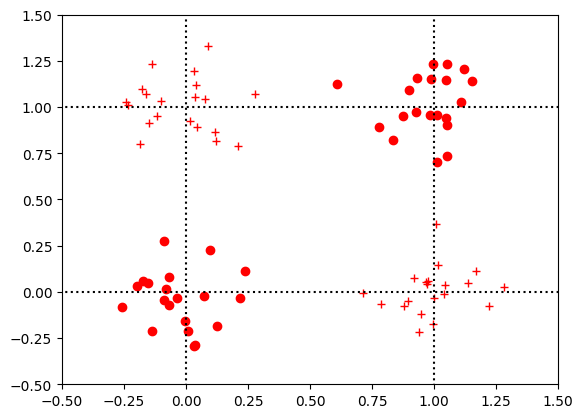

In [7]:
def vis_data(x,y = None, c = 'r'):
    if y is None:
        y = [None] * len(x)
    for x_, y_ in zip(x,y):
        if y_ is None:
            plt.plot(x_[0], x_[1], '*',markerfacecolor='none', markeredgecolor=c)
        else:
            plt.plot(x_[0], x_[1], c+'o' if y_ == 0 else c+'+')

plt.figure()
vis_data(x_train, y_train, c='r')
plt.plot([-1, 2], [0,0], linestyle = ":", color = 'k')
plt.plot([-1, 2], [1,1], linestyle = ":", color = 'k')
plt.plot([0, 0], [-1, 2], linestyle = ":", color = 'k')
plt.plot([1, 1], [-1,2], linestyle = ":", color = 'k')

plt.xlim([-0.5, 1.5])
plt.ylim([-0.5, 1.5])
plt.show()

In [8]:
x_train = torch.FloatTensor(x_train)
print(x_train.shape)
print(y_train.shape)
x_test = torch.FloatTensor(x_test)
y_train = torch.FloatTensor(y_train)
y_test = torch.FloatTensor(y_test)

torch.Size([80, 2])
(80,)


In [9]:
y_test.shape

torch.Size([20])

# Model

In [10]:
class NeuralNet(torch.nn.Module):
        def __init__(self, input_size, hidden_size):
            super(NeuralNet, self).__init__() # NeuralNet(자식 클래스)이 상속받는 torch.nn.Module(부모 클래스)을 우리의 NeuralNet에 불러오겠다는 의미
            self.input_size = input_size      # init 시 self.를 앞에 붙여줘야 함.
            self.hidden_size  = hidden_size

            self.linear_1 = torch.nn.Linear(self.input_size, self.hidden_size)
            self.relu = torch.nn.ReLU()
            ### 수정 ###
            # self.linear_2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
            ############
            self.linear_last = torch.nn.Linear(self.hidden_size, 1)   # Binary Classification(classes: 2)
            self.sigmoid = torch.nn.Sigmoid()                         # 0~1

        def forward(self, input_tensor):
            x = self.linear_1(input_tensor)
            x = self.relu(x)
            x = self.linear_last(x)
            output = self.sigmoid(x)
            return output

In [11]:
learning_rate = 0.01
epochs = 2000
hidden_size = 5

### Model Initialize ###
model = NeuralNet(2, hidden_size)   # (Input size, Hidden size)

criterion = torch.nn.BCELoss()  # Binary Cross-Entropy
# torch.nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate) # Stochastic Gradient Descent

In [12]:
# print(model)

In [13]:
model.eval() # Gradient Backpropagation(역전파)를 중지 -> Validation 및 Test 시에 사용

test_loss_before = criterion(model(x_test).squeeze(), y_test)
print('Before Training, test loss is {}'.format(test_loss_before.item()))

Before Training, test loss is 0.69706791639328


In [14]:
print(model(x_test).shape)
print(model(x_test).squeeze().shape)

torch.Size([20, 1])
torch.Size([20])


In [15]:
# 한 번 학습(1 epoch)
model.train()   # Gradient Update 실행.
optimizer.zero_grad()   # Gradient를 0으로 초기화
train_output = model(x_train)
train_loss = criterion(train_output.squeeze(), y_train)
train_loss.backward() # Backpropagation
optimizer.step()

In [16]:
train_losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    train_output = model(x_train)
    train_loss = criterion(train_output.squeeze(), y_train)
    if epoch % 100 == 0:
        print('Train loss at {} is {}'.format(epoch, train_loss.item()))
        train_losses.append(train_loss.item())
        torch.save(model.state_dict(), './model_epoch{}.pt'.format(epoch))
    train_loss.backward()
    optimizer.step()

Train loss at 0 is 0.6960088014602661
Train loss at 100 is 0.6897729635238647
Train loss at 200 is 0.6835647821426392
Train loss at 300 is 0.6768510937690735
Train loss at 400 is 0.6687192320823669
Train loss at 500 is 0.6592322587966919
Train loss at 600 is 0.6482009887695312
Train loss at 700 is 0.6366168260574341
Train loss at 800 is 0.6247779130935669
Train loss at 900 is 0.6133040189743042
Train loss at 1000 is 0.6014286875724792
Train loss at 1100 is 0.5887228846549988
Train loss at 1200 is 0.5750950574874878
Train loss at 1300 is 0.5605222582817078
Train loss at 1400 is 0.5450378656387329
Train loss at 1500 is 0.5288383960723877
Train loss at 1600 is 0.5118974447250366
Train loss at 1700 is 0.4943598806858063
Train loss at 1800 is 0.47657495737075806
Train loss at 1900 is 0.45851749181747437


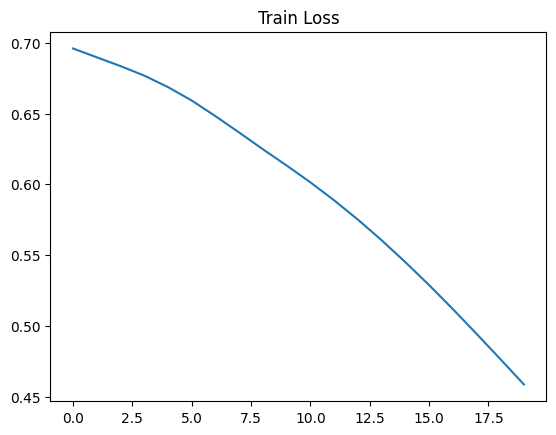

In [17]:
# train loss 그래프

plt.plot(train_losses)
plt.title('Train Loss')
plt.show()

In [18]:
model.eval()
test_loss = criterion(model(x_test).squeeze(), y_test)
print('After Training, test loss is {}'.format(test_loss.item()))

After Training, test loss is 0.425701379776001


In [19]:
torch.save(model.state_dict(), './model.pt')
print('state_dict format of the model: {}'.format(model.state_dict()))

state_dict format of the model: OrderedDict([('linear_1.weight', tensor([[ 0.5425,  0.5859],
        [-1.0864,  1.0596],
        [-0.1540,  0.1458],
        [-0.1942,  0.4085],
        [ 1.1200, -1.0780]])), ('linear_1.bias', tensor([ 0.6351, -0.0524,  0.5188,  0.2581, -0.0227])), ('linear_last.weight', tensor([[-0.1745,  1.3992, -0.0353, -0.1210,  1.2870]])), ('linear_last.bias', tensor([-0.4150]))])


In [20]:
# 새로운 모델에 학습된 가중치 로드

new_model = NeuralNet(2, hidden_size)

new_model.load_state_dict(torch.load('./model.pt'))

new_model.eval()
print('벡터 [0, 1]이 레이블 1을 가질 확률은 {}'.format\
      (new_model(torch.FloatTensor([0,1])).item()))

벡터 [0, 1]이 레이블 1을 가질 확률은 0.6631218194961548


In [21]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round((y_pred)).squeeze()

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [22]:
new_model.eval()
print(torch.round(new_model(x_test)).squeeze())
print(y_test)
print(binary_acc(new_model(x_test), y_test))

tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
        0., 1.], grad_fn=<SqueezeBackward0>)
tensor([0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
        0., 1.])
tensor(100.)


In [23]:
# Train epoch마다 성능 평가

for i in range(0,2000,100):
    new_model = NeuralNet(2, hidden_size)
    new_model.load_state_dict(torch.load('./model_epoch{}.pt'.format(i)))
    new_model.eval()
    print("======epoch : {} =======".format(i))
    print(binary_acc(new_model(x_test), y_test))

======epoch : 0 =======
tensor(50.)
======epoch : 100 =======
tensor(50.)
======epoch : 200 =======
tensor(40.)
======epoch : 300 =======
tensor(65.)
======epoch : 400 =======
tensor(95.)
======epoch : 500 =======
tensor(100.)
======epoch : 600 =======
tensor(100.)
======epoch : 700 =======
tensor(100.)
======epoch : 800 =======
tensor(100.)
======epoch : 900 =======
tensor(100.)
======epoch : 1000 =======
tensor(100.)
======epoch : 1100 =======
tensor(100.)
======epoch : 1200 =======
tensor(100.)
======epoch : 1300 =======
tensor(100.)
======epoch : 1400 =======
tensor(100.)
======epoch : 1500 =======
tensor(100.)
======epoch : 1600 =======
tensor(100.)
======epoch : 1700 =======
tensor(100.)
======epoch : 1800 =======
tensor(100.)
======epoch : 1900 =======
tensor(100.)
